In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats 
from shapely.geometry import Point
import shapely.speedups

plt.style.use('ggplot')
shapely.speedups.enable()
%matplotlib inline

In [2]:
nypd = pd.read_csv('../data/nypd.csv')
nypd['Date'] = pd.to_datetime(nypd['OCCUR_DATE'])
nypd = nypd.drop('OCCUR_DATE', axis=1)

In [3]:
nypd['Month'] = nypd.Date.dt.month 


In [4]:
nypd['Year'] = nypd.Date.dt.year

In [5]:
#dropping string object, need geometry
nypd = nypd.drop('Lon_Lat', axis=1)


In [6]:
#adding geometry objects for mapping
nypd['points'] = nypd.apply(lambda srs: Point( srs['Longitude'] , srs['Latitude']), axis=1)

In [7]:
#city-wide map
nyc = gpd.read_file('../data/map.geojson')

In [8]:
#making a geopandas dataframe to plot spatially 
geo_ny = gpd.GeoDataFrame(nypd)
geo_ny = geo_ny.set_geometry('points')

In [9]:
#merging nyc neighborhoods dataset with shooting dataset on coordinates being within the polygons of nyc dataset
whole = gpd.sjoin(geo_ny, nyc, how='left', op='within')
whole = whole.drop(['JURISDICTION_CODE','PERP_SEX', '@id', 'index_right'], axis=1)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


In [10]:
whole = whole.drop(['OCCUR_TIME', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'VIC_AGE_GROUP', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD'], axis =1)

In [11]:
whole = whole.drop('BORO', axis = 1)

In [12]:
#all murders
geo_k = gpd.GeoDataFrame(whole.loc[whole.STATISTICAL_MURDER_FLAG == True], geometry = 'points')

In [13]:
#dividing dataframes into boroughs
bronx = gpd.GeoDataFrame(whole.loc[whole.borough == 'Bronx'], geometry = 'points')
brooklyn = gpd.GeoDataFrame(whole.loc[whole.borough == 'Brooklyn'], geometry = 'points')
queens = gpd.GeoDataFrame(whole.loc[whole.borough == 'Queens'], geometry = 'points')
staten = gpd.GeoDataFrame(whole.loc[whole.borough == 'Staten Island'], geometry = 'points')
manhattan = gpd.GeoDataFrame(whole.loc[whole.borough == 'Manhattan'], geometry = 'points')

In [14]:
#dividing borough dataframes into 
bx_k = bronx.loc[bronx.STATISTICAL_MURDER_FLAG == True]
brooklyn_k = brooklyn.loc[brooklyn.STATISTICAL_MURDER_FLAG == True]
queens_k = queens.loc[queens.STATISTICAL_MURDER_FLAG == True]
staten_k = staten.loc[staten.STATISTICAL_MURDER_FLAG == True]
manhattan_k = manhattan.loc[manhattan.STATISTICAL_MURDER_FLAG == True]



In [15]:
#assigning total murders by borough
bx_killed, bk_killed, queens_killed, staten_killed, manhattan_killed = bx_k.count()['INCIDENT_KEY'], brooklyn_k.count()['INCIDENT_KEY'], queens_k.count()['INCIDENT_KEY'], staten_k.count()['INCIDENT_KEY'], manhattan_k.count()['INCIDENT_KEY']

In [16]:
#dividing dataset into pre-2013, post-2013, and 2013
pre = gpd.GeoDataFrame(whole.loc[whole.Year < 2013], geometry = 'points')
post = gpd.GeoDataFrame(whole.loc[whole.Year > 2013], geometry = 'points')
stop = gpd.GeoDataFrame(whole.loc[whole.Year == 2013], geometry = 'points')

In [17]:
#pre-2013, post-2013, 2013 murders
pre_k = gpd.GeoDataFrame(pre[pre.STATISTICAL_MURDER_FLAG == True], geometry = 'points')
post_k = gpd.GeoDataFrame(post[post.STATISTICAL_MURDER_FLAG == True], geometry = 'points')
stop_k = gpd.GeoDataFrame(stop[stop.STATISTICAL_MURDER_FLAG == True], geometry = 'points')



In [18]:
len(geo_ny) , len(whole)

(23568, 23568)

In [19]:
#geodataframes of kills by boro
geo_bronx = geo_k.loc[geo_k.borough == 'Bronx']
geo_bk = geo_k.loc[geo_k.borough == 'Brooklyn']
geo_qns = geo_k.loc[geo_k.borough == 'Queens']
geo_st = geo_k.loc[geo_k.borough == 'Staten Island']
geo_mn = geo_k.loc[geo_k.borough == 'Manhattan']

In [20]:
#borough maps
bronx_map = nyc[nyc.borough == 'Bronx']
brooklyn_map = nyc[nyc.borough == 'Brooklyn']
queens_map = nyc[nyc.borough == 'Queens']
manhattan_map = nyc[nyc.borough == 'Manhattan']
staten_map = nyc[nyc.borough == 'Staten Island']

In [21]:
#setting all geodataframes to same coordinate referencing system
gdfs = [geo_k, pre, post, stop, pre_k, post_k, stop_k, geo_bronx, geo_bk, geo_qns, geo_st, geo_mn, geo_ny,bronx_map, brooklyn_map, queens_map, manhattan_map, staten_map, brooklyn, bronx, queens, manhattan, staten]
for df in gdfs:
    df.crs = {'init': 'epsg:4326'}


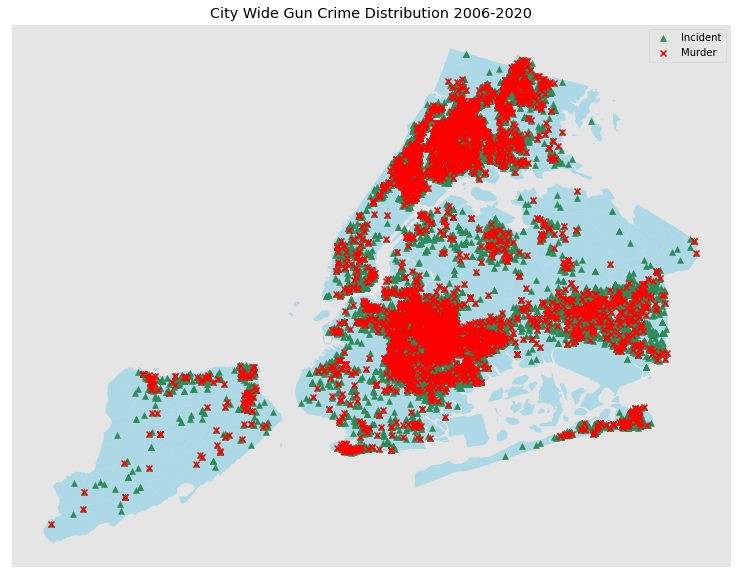

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
nyc.plot(color = 'lightblue', ax=ax)
geo_ny.plot(marker = '^', color = 'seagreen', ax = ax, label = 'Incident')
geo_k.plot(marker = 'x', color = 'red', ax = ax, label = 'Murder')
ax.set_title('City Wide Gun Crime Distribution 2006-2020')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('../images/City-Wide.png');

In [24]:
total_deaths_by_year = []
for name, group in geo_k.groupby('Year'):
    total_deaths_by_year.append(group.count()['INCIDENT_KEY'])

In [25]:
total_deaths_by_year = np.array(total_deaths_by_year)

In [26]:
total_incidents_by_year = []
for name, group in nypd.groupby('Year'):
    total_incidents_by_year.append(group.count()['INCIDENT_KEY'])
    

In [27]:
total_incidents_by_year = np.array(total_incidents_by_year)

In [28]:
rate_of_murder = total_deaths_by_year / total_incidents_by_year 

In [29]:
murder_rate = pd.Series(rate_of_murder, index=range(2006, 2021))

In [30]:
#initializing a dataframe for yearly stats
yearly = pd.DataFrame(murder_rate, columns = ['murder_rate'])

In [31]:
yearly['total_deaths'] = total_deaths_by_year
yearly['total_incidents_by_year'] = total_incidents_by_year 

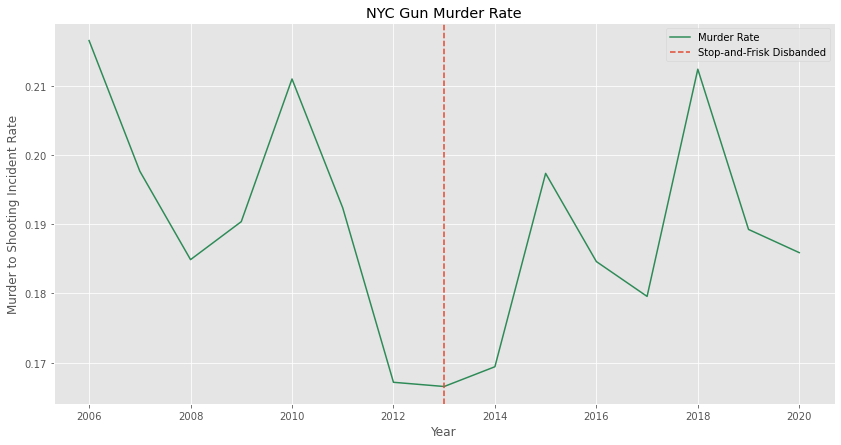

In [32]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yearly.index, yearly.murder_rate, color='seagreen', label='Murder Rate')
ax.axvline(2013, linestyle = '--', label = 'Stop-and-Frisk Disbanded')
ax.set_title('NYC Gun Murder Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Murder to Shooting Incident Rate')
plt.savefig('../images/Murder-Rate.png')
ax.legend();

In [33]:
#calculates borough murder rate by year 
def kill_stat(df, df_k):
    incidents = []
    deaths = []
    for name, group in df.groupby('Year'):
        incidents.append(group.count()['INCIDENT_KEY'])
    for name, group in df_k.groupby('Year'):
        deaths.append(group.count()['INCIDENT_KEY'])
    incidents = np.array(incidents)
    deaths = np.array(deaths)
    return deaths/incidents

In [40]:
yearly['Brooklyn'] = kill_stat(brooklyn, brooklyn_k)
yearly['Queens'] = kill_stat(queens, queens_k)
yearly['Manhattan'] = kill_stat(manhattan, manhattan_k)
yearly['Staten Island'] = kill_stat(staten, staten_k)
yearly['Bronx'] = kill_stat(bronx, bx_k)

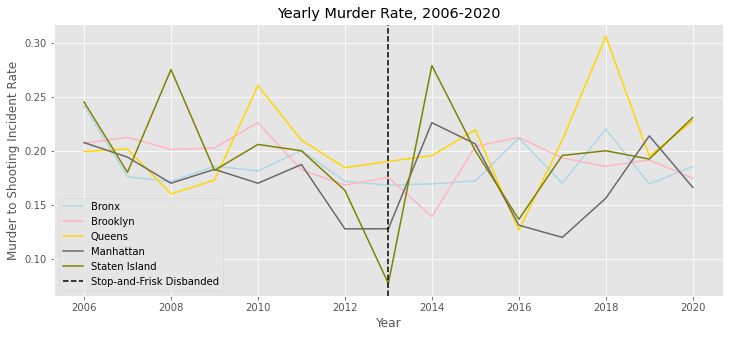

In [41]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(yearly.index, yearly.Bronx,color = 'lightblue', label = 'Bronx')
ax.plot(yearly.index,yearly.Brooklyn, color = 'lightpink', label = 'Brooklyn')
ax.plot(yearly.index,yearly.Queens, color = 'gold', label = 'Queens')
ax.plot(yearly.index,yearly.Manhattan, color='dimgray', label = 'Manhattan')
ax.plot(yearly.index,yearly['Staten Island'], color = 'olive', label = 'Staten Island')
ax.set_title('Yearly Murder Rate, 2006-2020')
ax.axvline(2013, linestyle = '--', color = 'black', label = 'Stop-and-Frisk Disbanded')
ax.set_xlabel('Year')
ax.set_ylabel('Murder to Shooting Incident Rate')
ax.legend()
plt.savefig('../images/yearly-rate.png');


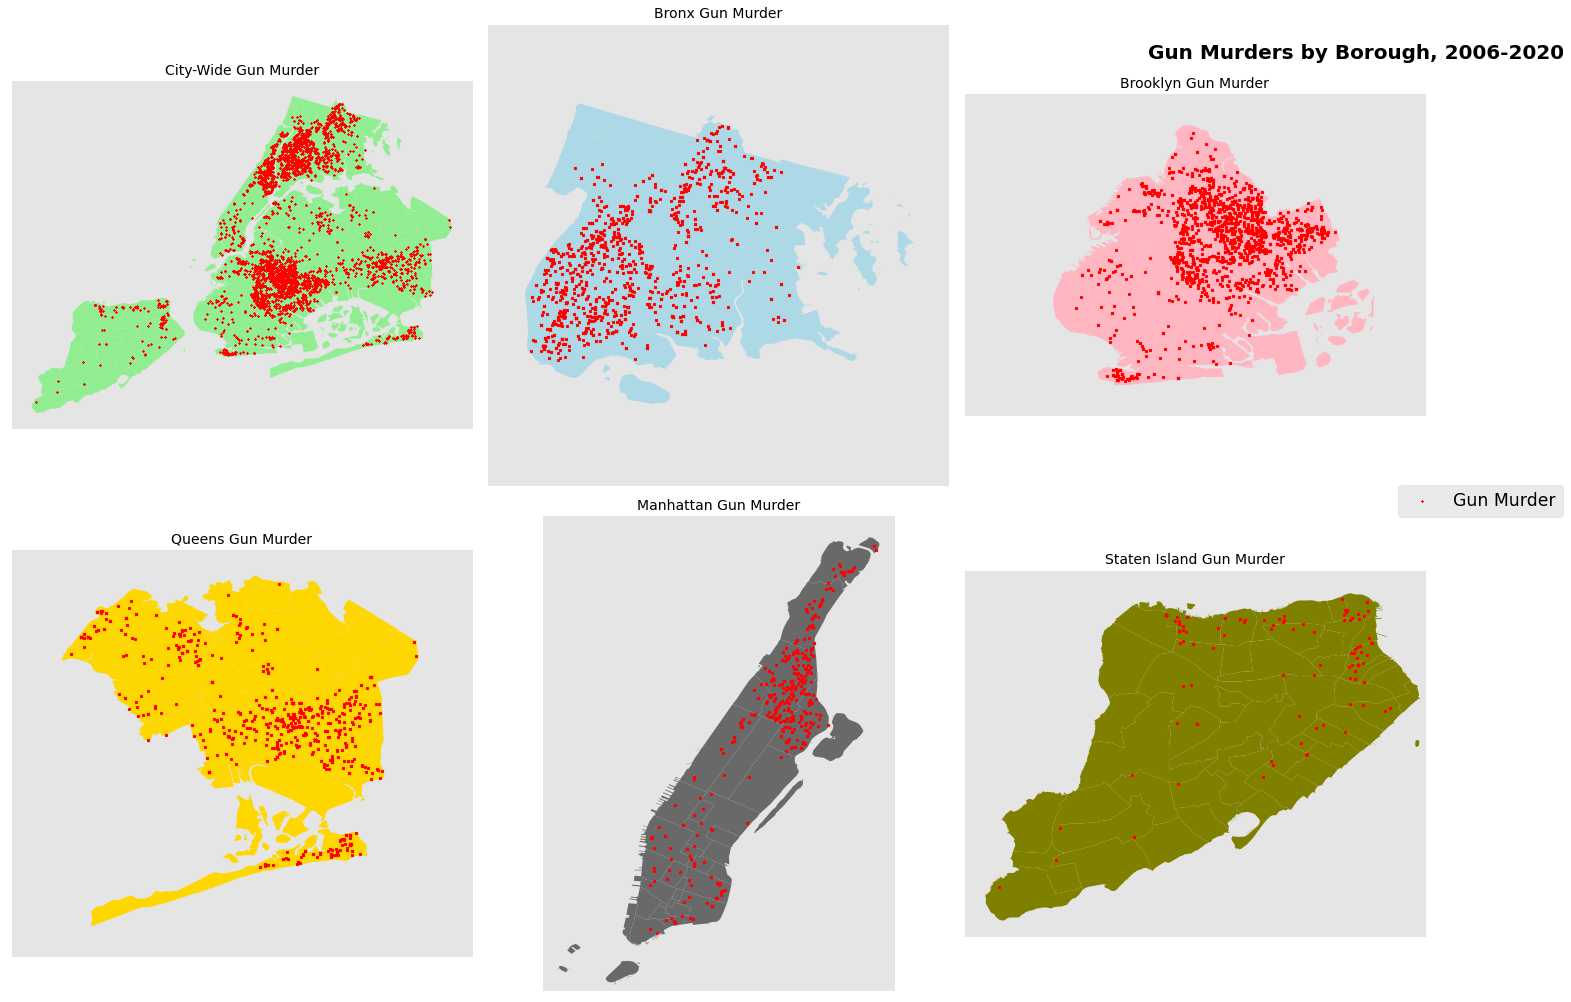

In [129]:
fig, axs = plt.subplots(2, 3, figsize=(20, 14))
axs=axs.flatten()

nyc.plot(ax=axs[0], color = 'lightgreen')
geo_k.plot(ax=axs[0], marker = "x", color = 'red', markersize = 2, label = 'Gun Murder')
axs[0].set_title('City-Wide Gun Murder', fontsize=14)


bronx_map.plot(ax=axs[1], color = 'lightblue')
geo_bronx.plot(ax=axs[1], color = 'red', marker = 'x', markersize=6)
axs[1].set_title('Bronx Gun Murder', fontsize=14)
axs[1].set_ylim(40.75, 40.95)
axs[1].set_xlim(-73.95, -73.75)


brooklyn_map.plot(ax=axs[2], color = 'lightpink')
geo_bk.plot(ax=axs[2], color = 'red', marker = 'x', markersize = 6)
axs[2].set_title('Brooklyn Gun Murder', fontsize=14)
axs[2].set_ylim(40.55, 40.76)
axs[2].set_xlim(-74.1, -73.8)


queens_map.plot(ax=axs[3], color = 'gold')
geo_qns.plot(ax=axs[3], color = 'red', marker = 'x', markersize = 6)
axs[3].set_title('Queens Gun Murder', fontsize=14)
axs[3].set_xlim(-74.0, -73.66)
axs[3].set_ylim(40.52, 40.82)

manhattan_map.plot(ax=axs[4], color = 'dimgray')
geo_mn.plot(ax=axs[4], color = 'red', marker = 'x', markersize = 6)
axs[4].set_title('Manhattan Gun Murder', fontsize=14)
axs[4].set_xlim(None,-73.9)
axs[4].set_ylim(40.68, None)

staten_map.plot(ax=axs[5], color = 'olive')
geo_st.plot(ax=axs[5], color = 'red', marker = 'x', markersize = 6)
axs[5].set_title('Staten Island Gun Murder', fontsize=14)
axs[5].set_xlim(None, -74.05)
axs[5].set_ylim(None, 40.66)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.text(.8, .94, 'Gun Murders by Borough, 2006-2020', fontsize=20, fontweight='bold')

fig.tight_layout()
fig.legend(loc='center right', fontsize='xx-large')
plt.savefig('../images/murder-map.png');

In [64]:
def total_dict(df, column):
    totals = dict()
    for name, group in df.groupby(column):
        totals[name] = group.count()[0]
    return totals


In [66]:
#getting pre 2013, post2013, and 2013 boro values of total incidents, total kills 
pre_boro_totals = total_dict(pre, 'borough')
post_boro_totals = total_dict(post, 'borough')
stop_boro_totals = total_dict(stop, 'borough')
pre_kills = total_dict(pre_k, 'borough')
post_kills = total_dict(post_k, 'borough')
at_kills = total_dict(stop_k, 'borough')


In [42]:
def dict_to_series(dct):
    idx = []
    vals = []
    for k, v in dct.items():
        idx.append(k)
        vals.append(v)
    out = pd.Series(vals, index=idx)
    return out 


In [67]:
#turning dicts to series for pandas dataframe with keys as index
pre_2013 = dict_to_series(pre_boro_totals)
post_2013 = dict_to_series(post_boro_totals)
at_2013 = dict_to_series(stop_boro_totals)
pre_2013_kills = dict_to_series(pre_kills)
post_2013_kills = dict_to_series(post_kills)
at_2013_kills = dict_to_series(at_kills)


In [73]:
#building dataframe for the two time periods
time = pd.DataFrame(pre_2013, columns = ['pre_2013_total'])
time ['post_2013_total'] = post_2013
time['2013_total'] = at_2013
time['pre_2013_kills'] = pre_2013_kills
time['post_2013_kills'] = post_2013_kills
time['2013_kills'] = at_2013_kills

In [75]:
time['pre_2013_rate'] = time['pre_2013_kills'] / time['pre_2013_total']
time['post_2013_rate'] = time['post_2013_kills'] / time['post_2013_total']
time['2013_rate'] = time['2013_kills'] / time['2013_total']

In [76]:
time

,pre_2013_total,post_2013_total,2013_total,pre_2013_kills,post_2013_kills,2013_kills,pre_2013_rate,post_2013_rate,2013_rate
Bronx,3766,2540,369,717,468,62,0.190388,0.184252,0.168022
Brooklyn,5530,3591,593,1111,658,104,0.200904,0.183236,0.175379
Manhattan,1656,1151,141,296,202,18,0.178744,0.175500,0.127660
Queens,1980,1367,184,391,287,35,0.197475,0.209949,0.190217
Staten Island,360,286,52,76,59,4,0.211111,0.206294,0.076923


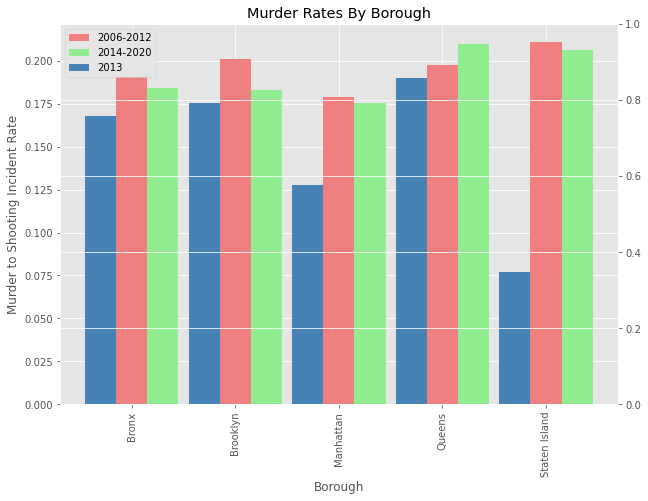

In [111]:
fig, ax = plt.subplots(figsize = (10, 7))
x = np.arange(5)
w = .3
plt.xticks(x, time.index, rotation='vertical')
pre_13 = ax.bar(x, time.pre_2013_rate, width=w,label = '2006-2012', color = 'lightcoral')
ax2 = ax.twinx()
post_2013 = ax.bar(x+w,time.post_2013_rate, width=w, color = 'lightgreen', label='2014-2020')
at_2013 = ax.bar(x-w, time['2013_rate'], width=w, color= 'steelblue', label='2013')
ax.legend()
ax.set_title('Murder Rates By Borough')
ax.set_xlabel ('Borough')
ax.set_ylabel('Murder to Shooting Incident Rate')
plt.savefig('../images/murder-rate-bar.png');

In [115]:
yearly

,murder_rate,total_deaths,total_incidents_by_year,Brooklyn,Queens,Manhattan,Staten Island,Bronx
2006,0.216545,445,2055,0.207059,0.199324,0.207612,0.245283,0.241623
2007,0.197668,373,1887,0.212485,0.201681,0.194093,0.180000,0.175803
2008,0.184883,362,1958,0.201274,0.160000,0.169884,0.275362,0.171484
2009,0.190372,348,1828,0.202597,0.172662,0.182741,0.181818,0.185606
2010,0.210995,403,1910,0.226087,0.260417,0.169884,0.205882,0.181298
2011,0.192367,373,1939,0.182360,0.209924,0.187215,0.200000,0.200351
2012,0.167152,287,1717,0.168210,0.184300,0.127551,0.163265,0.171698
2013,0.166542,223,1339,0.175379,0.190217,0.127660,0.076923,0.168022
2014,0.169399,248,1464,0.138889,0.195455,0.226027,0.279070,0.169300
2015,0.197350,283,1434,0.204117,0.219512,0.206349,0.200000,0.171990


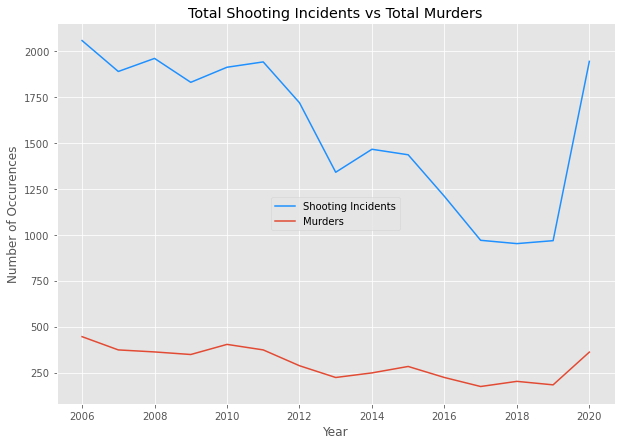

In [124]:
fig, ax = plt.subplots(figsize=(10,7))
ax = yearly.total_incidents_by_year.plot(color = 'dodgerblue',label='Shooting Incidents')
ax = yearly.total_deaths.plot(label = 'Murders')
ax.set_title('Total Shooting Incidents vs Total Murders')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Occurences')
ax.legend(loc='center')
